In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()

#  Setup credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d akashdeepkuila/bakery

# Unzip dataset
!unzip bakery.zip

Saving kaggle.json to kaggle (6).json
Dataset URL: https://www.kaggle.com/datasets/akashdeepkuila/bakery
License(s): CC0-1.0
bakery.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bakery.zip
replace Bakery.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace bakery_sales_revised.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
# Import dataset
import pandas as pd

df = pd.read_csv('Bakery.csv')
df.head()

,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Bread,2016-10-30 09:58:11,Morning,Weekend
1,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
2,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
3,3,Hot chocolate,2016-10-30 10:07:57,Morning,Weekend
4,3,Jam,2016-10-30 10:07:57,Morning,Weekend


In [ ]:
# Memisahkan kolom DateTime menjadi Month dan Year
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day

month_order = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
df['Month'] = df['DateTime'].dt.month.map(month_order)

# Menambahkan nama hari
df['Day_Name'] = df['DateTime'].dt.day_name()

# Mengelompokkan hari ke DayType
df['DayType'] = df['Day_Name'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

In [ ]:
# Mengambil hanya data tahun Januari 2017
df = df[(df['Year'] == 2017) & (df['Month'] == 'January')]

In [ ]:
# Mengelompokkan transaksi berdasarkan TransactionNo
# Hanya 2 kolom
# df_grouped = df.groupby('TransactionNo')['Items'].agg(list).reset_index()

# Menambahkan kolom lainnya
df_grouped = df.groupby('TransactionNo').agg({
    'Items': list,
    'Day': 'first',
    'Day_Name': 'first',
    'Daypart': 'first'
}).reset_index()

### **Eksplorasi dan Visualisasi**

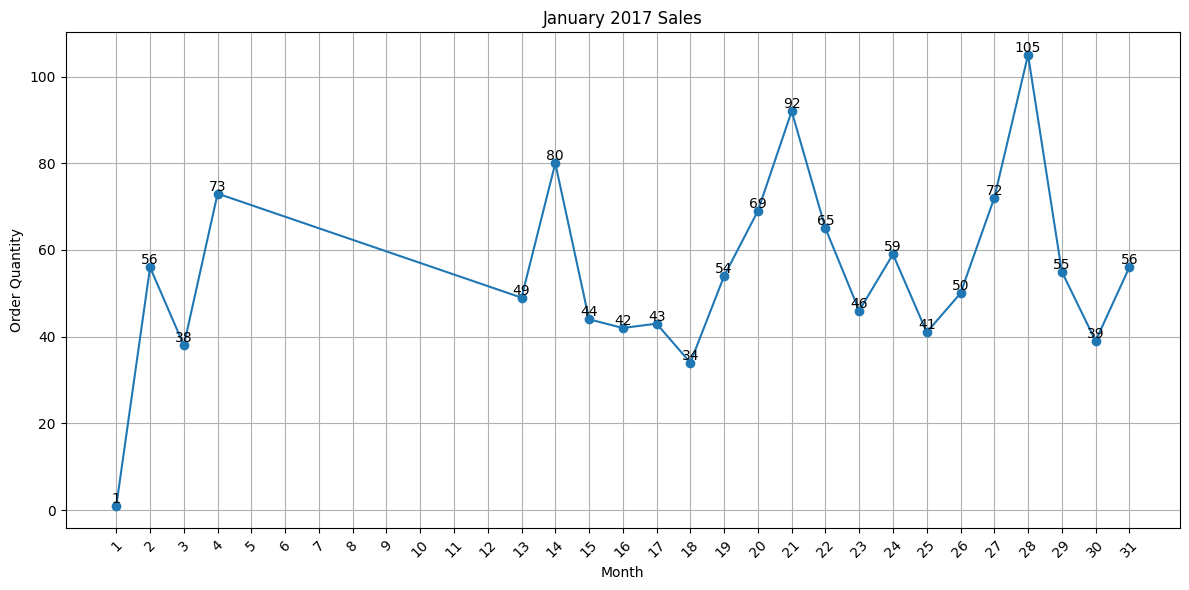

In [ ]:
# Time Series Visualization for Transaction Count
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

monthly = df_grouped.groupby('Day').size()

plt.figure(figsize=(12, 6))
plt.plot(monthly.index, monthly.values, marker='o', linestyle='-')
plt.title('January 2017 Sales')
plt.xlabel('Month')
plt.ylabel('Order Quantity')
plt.grid(True)
full_days = np.arange(1, 32)
daily_counts = monthly.reindex(full_days, fill_value=0)
plt.xticks(full_days, rotation=45)

for i, v in enumerate(monthly.values):
    plt.text(monthly.index[i], v, format(v), ha='center', va='bottom')

formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

In [ ]:
# Menampilkan rata-rata penjualan harian
sales = df_grouped.groupby('Day').size()
print("Jumlah penjualan selama Januari 2017:", sales.sum())
print("Rata-rata penjualan harian:", sales.mean().round())

Jumlah penjualan selama Januari 2017: 1263
Rata-rata penjualan harian: 55.0


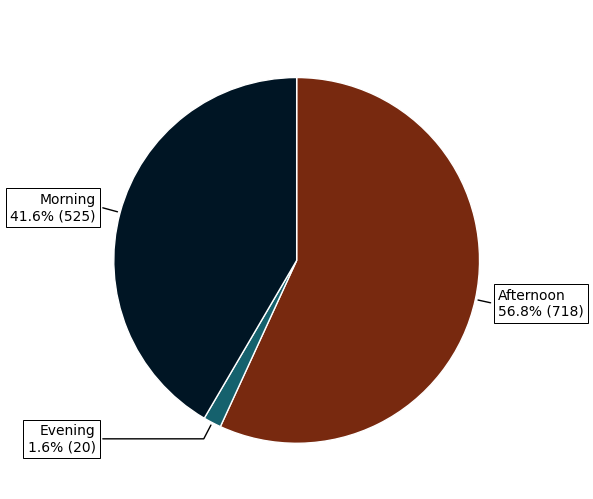

In [ ]:
# Pie Chart
import numpy as np

# Mengatur palet warna
colors = ['#78290f', '#15616d', '#001524', '#ffecd1']

# Fungsi untuk membuat Pie Chart
def create_pie_chart(data, ax, title, colors):
    categories = data.index
    values = data.values
    total = sum(values)

    # Membuat Pie Chart
    wedges, texts = ax.pie(values,
                           colors=colors,
                           startangle=90,
                           counterclock=False,
                           wedgeprops={'linewidth': 1, 'edgecolor': 'white'})

    # Membuat Label Kustom
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, wedge in enumerate(wedges):
        angle = (wedge.theta1 + wedge.theta2) / 2
        y = np.sin(np.deg2rad(angle))
        x = np.cos(np.deg2rad(angle))
        horizontalalignment = "left" if x > 0 else "right"  # Perbaikan di sini
        connectionstyle = "angle,angleA=0,angleB={}".format(angle)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        percentage = values[i] / total * 100
        label_text = f"{categories[i]}\n{percentage:.1f}% ({values[i]})"
        ax.annotate(label_text, xy=(x, y), xytext=(1.1*np.sign(x), 1.1*y),
                    horizontalalignment=horizontalalignment, **kw)

    ax.set_title(title)

# Grouping Data
daypart_data = df_grouped.groupby('Daypart').size()

# Membuat Layout Plot
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
fig.set_facecolor('white')

# Membuat Pie Chart
create_pie_chart(daypart_data, axes, ' ', colors)

# Mengatur Layout dan Menampilkan Plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Berdasarkan waktu dalam satu hari, sebagian besar (58,7%) transaksi dilakukan di siang hari.

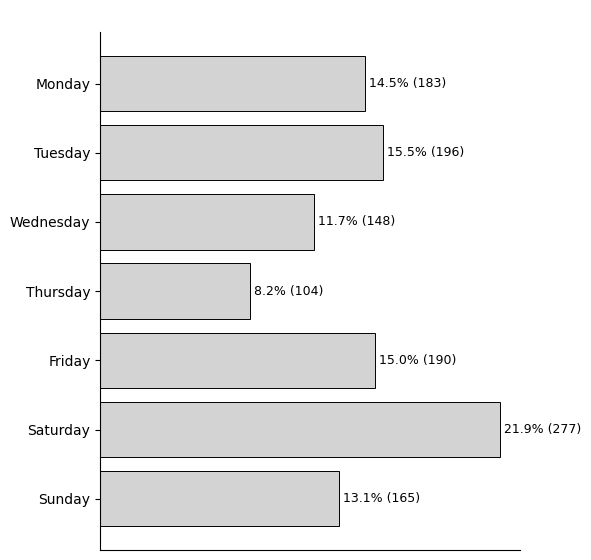

In [ ]:
# Bar Chart
# Fungsi untuk membuat Horizontal Bar Chart
def create_hbar_chart(data, ax, title, colors):
    categories = data.index
    values = data.values
    total = sum(values)

    # Membuat Horizontal Bar Chart
    bars = ax.barh(categories, values, color='lightgrey', edgecolor='black', linewidth=0.7)

    # Menambahkan persentase dan nilai di samping bar
    for i, (value, category) in enumerate(zip(values, categories)):
        percentage = value / total * 100
        ax.text(value + (0.01 * max(values)),  # Posisi teks di ujung kanan bar
                i,  # Posisi vertikal sesuai kategori
                f'{percentage:.1f}% ({value:,.0f})',
                va='center',
                ha='left',
                fontsize=9)

    # Formatting
    ax.set_title(title)
    ax.grid(False)
    ax.set_axisbelow(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])

# Grouping
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_order.reverse()
day_data = df_grouped.groupby('Day_Name').size()
day_data = day_data.reindex(day_order)

# Membuat Layout Plot
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
fig.set_facecolor('white')

# Membuat Horizontal Bar Chart
create_hbar_chart(day_data, axes, ' ', colors)

# Mengatur Layout dan Menampilkan Plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Berdasarkan hari, sebagian besar (18,3%) transaksi dilakukan di hari Sabtu.

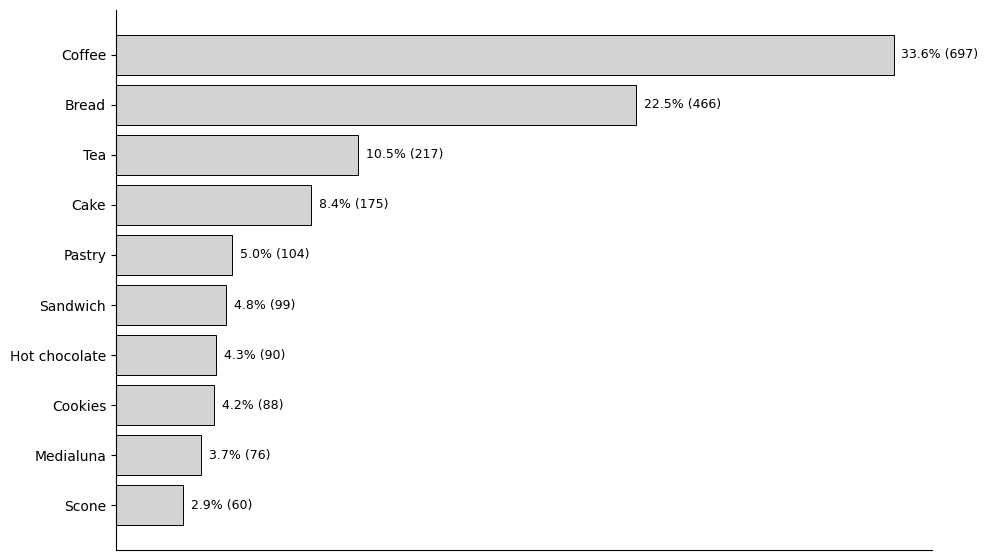

In [ ]:
# Grouping
items_data = df.groupby('Items').size().nlargest(10).sort_values(ascending=True)

# Membuat Layout Plot
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
fig.set_facecolor('white')

# Membuat Horizontal Bar Chart
create_hbar_chart(items_data, axes, '', colors)

# Mengatur Layout dan Menampilkan Plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Berdasarkan jumlah transaksi, menu yang paling banyak dibeli adalah kopi dan roti.

### **Analisis Aturan Asosiasi**

In [ ]:
# Jika 1 produk untuk 1 kolom sehingga lebih dari 1 produk dalam beberapa kolom
# Gabungkan semua judul dalam satu list per baris, tanpa NaN
# transactions = df.apply(lambda row: [item for item in row if pd.notnull(item)], axis=1).tolist()

In [ ]:
# Jika 1 produk untuk satu baris dalam 1 kolom sehingga lebih dari 1 produk dalam beberapa baris
# Gabungkan semua judul dalam satu list per baris, tanpa NaN
transactions = df.groupby('TransactionNo')['Items'].agg(list).tolist()

In [ ]:
# Transaction encoding
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_data = te.fit_transform(transactions)
df_encoded = pd.DataFrame(te_data, columns=te.columns_)

In [ ]:
# Analisis aturan asosiasi
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(df_encoded, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

print(rules[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence']])

  antecedents consequents  antecedent support  consequent support   support  \
0    (Coffee)     (Bread)            0.462391            0.346793  0.094220   
1     (Bread)    (Coffee)            0.346793            0.462391  0.094220   
2      (Cake)    (Coffee)            0.133808            0.462391  0.068092   
3       (Tea)    (Coffee)            0.163895            0.462391  0.065717   

   confidence  
0    0.203767  
1    0.271689  
2    0.508876  
3    0.400966  
